<a href="https://colab.research.google.com/github/Thiago-Emidio-Silva/artigo_Levantamento-de-caracter-sticas-de-coagula-o-para-tratamento-de-gua-pot-vel/blob/main/Segmentacao_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Levantamento de características de coagulação para tratamento de água potável**

Thiago Emidio da Silva – 118772
Departamento de Engenharia Elétrica – Especialização em Inteligência Artificial e Computacional
Universidade Federal de Viçosa. Viçosa – MG -- Thiago.emidio@ufv.br


In [30]:
#Permição para acessar o google drive se necessário
from google.colab import drive
drive.mount('/content/drive')

#Carregar as bibliotecas necessarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
import os
from skimage.io import imread, imshow
from scipy import stats
from google.colab import output


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IREMOS ANALIZAR AS PROPRIEDADES DAS IMAGENS

In [31]:
#Vamos ler a imagem

import os
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt

# Caminho da pasta de imagens no Google Drive ou local do Colab
pasta_imagens = '/content/drive/MyDrive/img_floc_256/train/'

# Listar arquivos de imagem
arquivos = [f for f in os.listdir(pasta_imagens) if f.lower().endswith(('.jpeg'))]
indice_atual = 0  # Iniciar o índice da primeira imagem


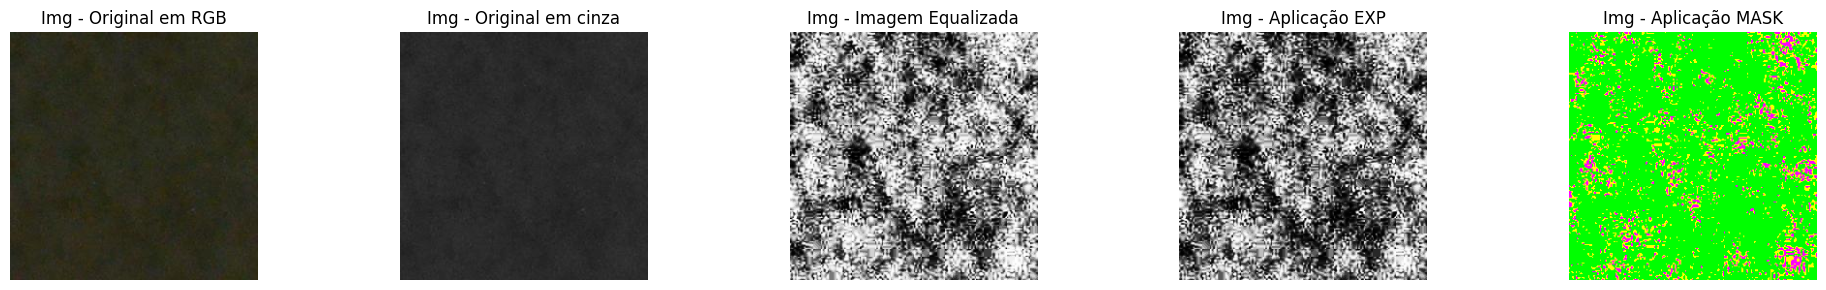

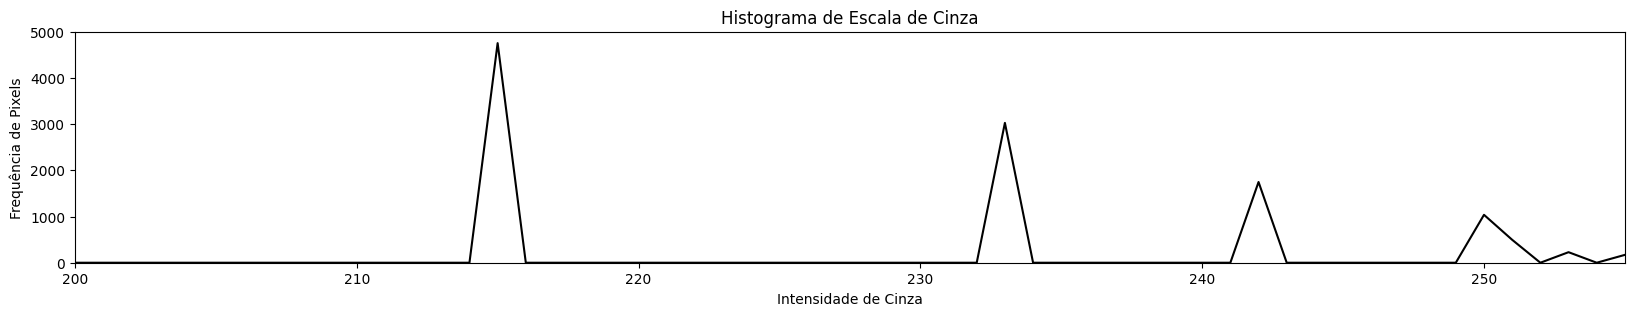

indice_atual = 11 val_contorno = 201 val_centro = 241


In [32]:
# Valores de contorno e centro
val_contorno = 200
val_centro = 240
indice_atual = 0  # Inicializa o índice atual (ajuste conforme necessário)

def imagem_processada(file_name):
    """Verifica se a máscara da imagem já foi processada."""
    mask_path = os.path.join(pasta_imagens, f'{file_name}.png')
    return os.path.exists(mask_path)

def processar_imagem():
    global indice_atual, file_name, img_mask
    if indice_atual >= len(arquivos):
        print("Processamento concluído. Não há mais imagens.")
        return

    caminho_arquivo = os.path.join(pasta_imagens, arquivos[indice_atual])
    file_name = os.path.splitext(os.path.basename(caminho_arquivo))[0]

    # Verifica se a imagem já foi processada
    if imagem_processada(file_name):
        print(f"A imagem '{file_name}' já foi processada. Pulando...")
        indice_atual += 1  # Avança para a próxima imagem
        processar_imagem()  # Chama novamente para processar a próxima imagem
        return

    # Limpar a saída para exibir a próxima imagem
    clear_output(wait=True)

    # Carregar a imagem
    img_org = cv2.imread(caminho_arquivo)
    img_gray = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)

    # Equalização e transformação exponencial
    img_equ = cv2.equalizeHist(img_gray)
    img_equ_exp = img_equ / 255.0
    img_exp = np.exp(img_equ_exp) - 1
    img_exp = (img_exp - img_exp.min()) / (img_exp.max() - img_exp.min()) * 255
    img_exp = np.uint8(img_exp)

    # Criação da máscara colorida
    img_mask = np.zeros((img_org.shape[0], img_org.shape[1], 3), dtype=np.uint8)
    img_mask[:] = (0, 255, 0)
    img_mask[img_exp > val_contorno] = (0, 255, 255)

    # Criar máscara binária e pintar o centro de roxo
    center_mask = cv2.threshold(img_exp, val_centro, 255, cv2.THRESH_BINARY)[1]
    img_mask[center_mask == 255] = (255, 0, 255)

    # Salvar a máscara
    #cv2.imwrite(os.path.join(caminho_pasta_processadas, f'{file_name}.png'), img_mask)
    #cv2.imwrite(os.path.join(caminho_pasta_processadas, f'{file_name}.jpeg'), img_org)

    # Visualização das imagens
    fig, axs = plt.subplots(1, 5, figsize=(20, 3))
    axs[0].imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title("Img - Original em RGB")
    axs[1].imshow(cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB))
    axs[1].axis('off')
    axs[1].set_title("Img - Original em cinza")
    axs[2].imshow(cv2.cvtColor(img_equ, cv2.COLOR_GRAY2RGB))
    axs[2].axis('off')
    axs[2].set_title("Img - Imagem Equalizada")
    axs[3].imshow(cv2.cvtColor(img_exp, cv2.COLOR_GRAY2RGB))
    axs[3].axis('off')
    axs[3].set_title("Img - Aplicação EXP")
    axs[4].imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
    axs[4].axis('off')
    axs[4].set_title("Img - Aplicação MASK")
    plt.tight_layout()
    plt.show()

    # Plotar o histograma
    hist = cv2.calcHist([img_exp], [0], None, [256], [0, 256])
    plt.figure(figsize=(20, 3))
    plt.plot(hist, color='black')
    plt.title("Histograma de Escala de Cinza")
    plt.xlabel("Intensidade de Cinza")
    plt.ylabel("Frequência de Pixels")
    plt.xlim([200, 255])
    plt.ylim([0, 5000])
    plt.show()

    # Adicionar botões para Aprovar e Refazer
    display(HTML('''<form>
        <input type="button" value="Aprovar" onclick="google.colab.kernel.invokeFunction('aprovar_imagem', [], {});">
        <input type="button" value="Refazer" onclick="google.colab.kernel.invokeFunction('refazer_imagem', [], {});">
    </form>'''))

    print('indice_atual =', indice_atual, 'val_contorno =', val_contorno, 'val_centro =', val_centro)

# Funções de callback para os botões

# Aprovar: avança para a próxima imagem
def aprovar_imagem():
    global val_contorno, val_centro, indice_atual

    # Salvar a máscara
    cv2.imwrite(pasta_imagens + file_name + '.png', img_mask)
    #print('Aprovado_2')

    # Avançar para a próxima imagem
    indice_atual += 1
    val_contorno = 200
    val_centro = 240
    processar_imagem()

# Refazer: mantém o índice atual e processa novamente
def refazer_imagem():
    global val_contorno, val_centro, indice_atual
    val_contorno += 1
    val_centro += 1
    processar_imagem()

output.register_callback('aprovar_imagem', aprovar_imagem)
output.register_callback('refazer_imagem', refazer_imagem)

# Chamar a função para exibir a primeira imagem
processar_imagem()
